# Learning from an optimization perspective

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import fsolve
import time as time

In [47]:
import algos_QP
import RandomWalk
from RandomWalk import Random_walk

In [48]:
reload(algos_QP)
reload(RandomWalk)

<module 'RandomWalk' from 'RandomWalk.pyc'>

# 1. Online algorithms

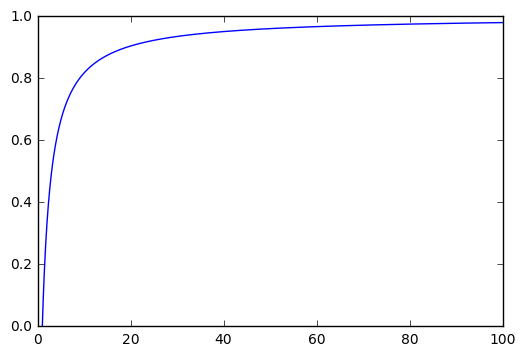

In [49]:
k=np.arange(10,1000)/10.
r=(k-1)/(k+1)
plt.plot(k,r)
plt.show()

In [50]:
nState=1000
nStep=100
nFeatures=100
gamma=0.9

P_pi,r_pi=Random_walk.compute_policy(nState,nStep)
Phi=Random_walk.compute_features(nState,nFeatures)

d_init=(1.0/nState)*np.ones(nState+1)
d_init[0]=0.0
problem=Random_walk(gamma=gamma,nState=nState,nStep=nStep,nAction=nState,nFeatures=nFeatures,
                    behaviour_policy=P_pi,r_pi=r_pi,d_init=d_init)

In [59]:
nIterTot=1000
nIter=25000
nRuns=nIterTot/nIter

verbose=True

algos=['TD']
#algos.append('LSTD')
#algos=['LSTD' for i in range(nRuns)]
#algos=['TD']

algos=['TDC_RMSProp','TDC','TDC_ADAM','TD']


nAlgos=len(algos)
com=['' for i in range(nAlgos)]

zeta=0.01*np.ones(nAlgos)
alpha=0.01*np.ones(nAlgos)
#alpha[1]=0.05
beta=0.05*np.ones(nAlgos)
gamma_=0.66*np.ones(nAlgos)
momentum=['None' for i in range(nAlgos)]
#momentum[3]='None'
#com[2]='+Adaptive Momentum'
#momentum[4]=True

theta=np.zeros((nAlgos,nIter+1,nFeatures+1))

for algo in enumerate(algos):
    #problem.restart()
    #np.random.seed(0)
    theta[algo[0],:]=problem.run_algo(algo[1],nIter_max=nIter,verbose=verbose,
                                   alpha_=alpha[algo[0]],beta_=beta[algo[0]], gamma_=gamma_[algo[0]],
                                   zeta_=zeta[algo[0]],
                                   momentum=momentum[algo[0]],
                                   epsilon_LSTD=10.)
    


Algo: TDC_RMSProp 	 | Time (s): 1.57349784615
Algo: TDC 	 | Time (s): 1.2778014359
Algo: TDC_ADAM 	 | Time (s): 2.15127712821
Algo: TD 	 | Time (s): 1.24429866667


In [60]:
#compute value function
v=np.zeros((nAlgos,nIter+1,problem.nState+1))
for algo in range(nAlgos):
    v[algo,:]=((problem.Phi).dot(theta[algo,:].T)).T
    
#compute true TD fixed point
#theta_TD_star = np.linalg.inv(problem.A_approx).dot(problem.b_approx)
n,t,v_TD_star=algos_QP.compute_valueFunction(
            P_pi,r_pi,discountFactor=gamma,
            algo='CG',nIter_max=nIter,x_init_=None,
            verbose=False,history=False,preconditionner=False)

#compute history of MSVE
MSPBE=np.zeros((nAlgos,nIter+1))
for algo in range(nAlgos):
    #MSVE[algo,:]=np.sum((problem.d_stationnary)*(v[algo,:]-v_TD_star)*(v[algo,:]-v_TD_star),1)
    MSPBE[algo,:]=problem.MSPBE(theta[algo,:])

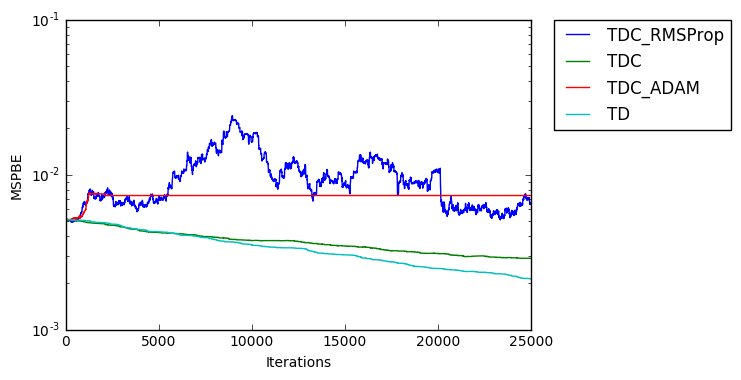

In [61]:
for algo in range(nAlgos):
    plt.semilogy(MSPBE[algo,:],label=algos[algo]+com[algo])
    #plt.plot(nRuns*np.arange(nIter+1),MSPBE[algo,:],color='pink')
    1
    
#plt.plot(nRuns*np.arange(nIter+1),MSPBE_,color='red',lw=2,label='LSTD')
#plt.plot(MSPBE_TD,color='b',lw=2,label='TD')
#plt.semilogy(MSVE[nAlgos-1,:],label=algos[algo]+' - g='+str(gamma[algo]),color='r',lw=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Iterations')
plt.ylabel('MSPBE')
#plt.axis([0,25000,0.01,0.2])
#plt.savefig('C:\Users\Mathieu\Dropbox\PolyMTL\Cours\COMP762 - Reinforcement Learning\Project\Presentation\images\Gradient_TD.png', bbox_inches='tight')

plt.show()

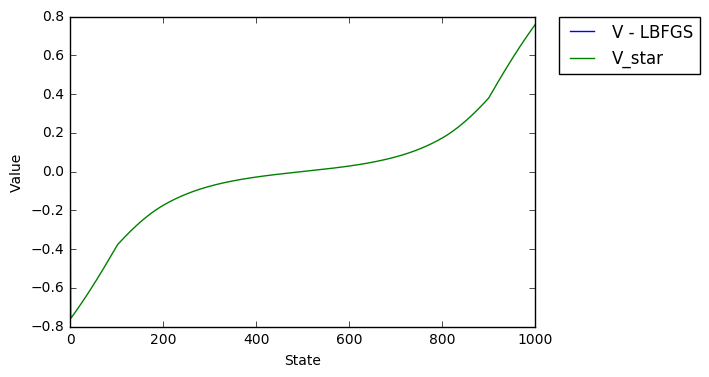

In [791]:
#plot the learned value functions
#plot the learning curves
for algo in range(nAlgos):
    plt.plot(v[algo,nIter,:],label='V - '+algos[algo])

plt.plot(v_TD_star,label='V_star')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 2.2 Tabular representation

In [560]:
reload(algos_QP)
reload(RandomWalk)

<module 'RandomWalk' from 'RandomWalk.pyc'>

In [16]:
nState=100
nStep=10
nFeatures=100
gamma=0.9

P_pi,r_pi=Random_walk.compute_policy(nState,nStep)
#eP,vP=np.linalg.eig(gamma*P_pi)
#P_pi+=0.1*np.eye(nState+1)

#P_pi=np.random.rand(nState+1,nState+1)
#P_pi=np.ones((nState+1,nState+1))+np.random.rand(nState+1,nState+1)
#P_pi=np.diag((1.+np.arange(nState+1))/1.)+np.random.rand(nState+1,nState+1)
#for s in range(nState+1):
    #P_pi[s,:]=P_pi[s,:]/np.sum(P_pi[s,:])
    
#P_pi=np.diag((1.+np.arange(nState+1))/(nState+1))
#P_pi[:,nState]+=1.-(1.+np.arange(nState+1))/(nState+1)
#eP_,vP=np.linalg.eig(gamma*P_pi)
#plt.scatter(eP,np.ones(nState+1))
#plt.scatter(eP_,1.+np.ones(nState+1))
#plt.axis([0,0.01,0,2])
#plt.show()

In [17]:
#First, compute value function in the tabular case
nIter=1000
history=True

gamma_=1.-0.1**(1+np.arange(5))
gamma_=np.array([0.3,0.5,0.9,0.95,0.99,0.995,0.999])
gamma_=np.array([0.99])


algos=['DP','GD','GD_am','AdaGrad','RMSProp','ADAM','CG','Newton']

nAlgos=len(algos)
t_algo=np.zeros((gamma_.shape[0],nAlgos))
nIter_algo=np.zeros((gamma_.shape[0],nAlgos))
err=np.zeros((gamma_.shape[0],nAlgos))
v_init=None

if(history):
    v=np.zeros((gamma_.shape[0],nAlgos,nIter+1,nState+1)) 
else:
    v=np.zeros((gamma_.shape[0],nAlgos,nState+1))

for g in enumerate(gamma_):
    for algo in enumerate(algos):
        
        n,t,v_res=algos_QP.compute_valueFunction(
            P_pi,r_pi,discountFactor=g[1],
            algo=algo[1],nIter_max=nIter,x_init_=v_init,
            verbose=True,history=history,preconditionner=False)
        
        v[g[0],algo[0],:]=v_res
        t_algo[g[0],algo[0]]=t
        nIter_algo[g[0],algo[0]]=n

    v_TD=v[g[0],nAlgos-1,nIter]

    #Now, compute errors
    if(history):
        err=np.zeros((gamma_.shape[0],nAlgos,nIter+1))
        for algo in enumerate(algos):
            err[g[0],algo[0],:]=np.max(np.abs(v[g[0],algo[0],:]-v_TD),1)

    else:
        for algo in enumerate(algos):
            
            err[g[0],algo[0]]=np.max(np.abs(v[g[0],algo[0],:]-v_TD))
            print 'Algo:',algo[1], '\t | final error:', err[g[0],algo[0]]
            #print 'Algo:',algo[1], '\t | Time:', t_algo[g[0],algo[0]]

Algo: DP 	 | Time (s): 0.0499068717949 	 | #Iter: 1000 	 | T/iter: 4.99068717949e-05
Algo: GD 	 | Time (s): 0.0853456410256 	 | #Iter: 1000 	 | T/iter: 8.53456410256e-05
Algo: GD_am 	 | Time (s): 0.0612648205128 	 | #Iter: 1000 	 | T/iter: 6.12648205128e-05
Algo: AdaGrad 	 | Time (s): 0.0688032820513 	 | #Iter: 1000 	 | T/iter: 6.88032820513e-05
Algo: RMSProp 	 | Time (s): 0.0852356923077 	 | #Iter: 1000 	 | T/iter: 8.52356923077e-05
Algo: ADAM 	 | Time (s): 0.0761948717949 	 | #Iter: 1000 	 | T/iter: 7.61948717949e-05
Algo: CG 	 | Time (s): 0.00265846153846 	 | #Iter: 49 	 | T/iter: 5.42543171114e-05
Algo: Newton 	 | Time (s): 0.0165128205128 	 | #Iter: 1 	 | T/iter: 0.0165128205128


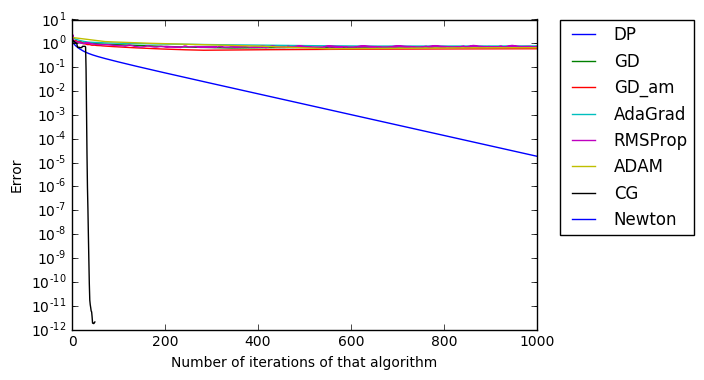

In [18]:
#plot the learning curves
plot_time=False

for algo in range(nAlgos):
    if(plot_time):
    
        plt.semilogy((t_algo[0,algo]/nIter_algo[0,algo])*np.arange(nIter_algo[0,algo]+1),err[0,algo,range(int(nIter_algo[0,algo]+1))],label=algos[algo])
        plt.xlabel('Running time (s)')
    else:
        plt.semilogy(np.arange(nIter_algo[0,algo]+1),err[0,algo,range(int(nIter_algo[0,algo]+1))],label=algos[algo])
        plt.xlabel('Number of iterations of that algorithm')
    
plt.ylabel('Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.savefig('C:\Users\Mathieu\Dropbox\PolyMTL\Cours\COMP762 - Reinforcement Learning\Project\Presentation\images\DP_QP.png', bbox_inches='tight')
plt.show()

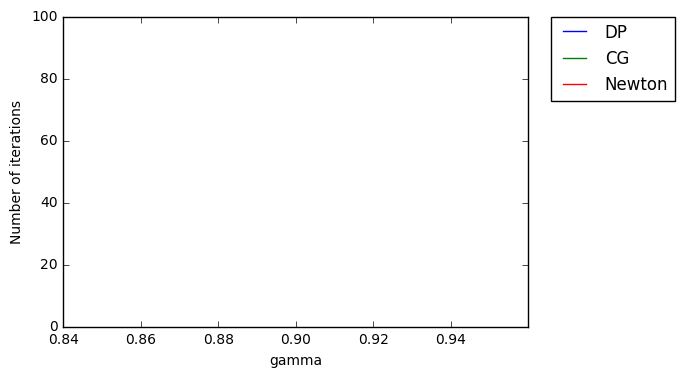

In [566]:
#plot total computation time with respect to gamma
plot_time=False

for algo in enumerate(algos):
    if(plot_time):

        plt.plot(gamma_,t_algo[:,algo[0]],label=algo[1])
        plt.ylabel('Solving time')
    else:
        plt.plot(gamma_,nIter_algo[:,algo[0]],label=algo[1])
        plt.ylabel('Number of iterations')

plt.xlabel('gamma')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.savefig('C:\Users\Mathieu\Dropbox\PolyMTL\Cours\COMP762 - Reinforcement Learning\Project\Presentation\images\DP_QP.png', bbox_inches='tight')
plt.show()

In [432]:
def policy_iteration(n,step,algo,gamma,nIterMax=100,nIter_PI_max=100):
    epsilon=10**-12
    v=np.zeros(n+2)
    #initial policy : stay where you are
    pi=np.arange(n+2)
    
    
    #random initial policy
    pi=np.random.randint(low=0,high=n+2,size=n+2)
    pi[0]=0
    pi[n+1]=n+1
    pi=np.arange(n+2)
    
    P_pi=np.zeros((n+2,n+2))
    for s in range(n+2):
        P_pi[s,pi[s]]=1.
    P_pi=np.eye(n+2)
    
    #reward is +1 when right end is reached, -1 when left end is reached
    r_pi=P_pi[:,n+1]#-P_pi[:,0]
    r_pi[0]=0.
    r_pi[n+1]=0.
    
    
    policy_change=True
    iter_count=0
    
    t_opt_tot=0.
    n_opt_tot=0
    
    start=time.clock()
    
    while(policy_change and iter_count<nIter_PI_max):

        #compute value function
        n_opt,t_opt,v=algos_QP.compute_valueFunction(
            P_pi,r_pi,discountFactor=gamma,
            algo=algo,nIter_max=nIterMax,x_init_=v,
            verbose=False,history=False,preconditionner=False)
        v[0]=0.
        v[n+1]=0.
        t_opt_tot+=t_opt
        n_opt_tot+=n_opt
        
        
        #improve the policy
        policy_change=False
        v_max=v
        for s in range(1,n+1):
            #find best action
            a_current=pi[s]
            a_max=a_current
            for a in range(max([0,s-step]),min([n+2,s+step])):
                #print a
                if(a==0):
                    v_=-1.
                elif(a==n+1):
                    v_=1.
                else:
                    v_=gamma*v[a]
                
                if(v_>v_max[s]+epsilon):
                    #print 'Better action:', s,a_max,a_current
                    v_max[s]=v_
                    a_max=a
            
            if(a_max!=a_current):
                #update policy
                if(np.random.rand()<0.0001):
                    print algo, iter_count, s,a_current, a_max, v[s], v_max[s]
                #update policy for this state
                pi[s]=a_max
                P_pi[s,:]=0.
                P_pi[s,a_max]=1.
                policy_change=True
                
        v=v_max
        #update r_pi
        r_pi=P_pi[:,n+1]#-P_pi[:,0]
        r_pi[0]=0.
        r_pi[n+1]=0.
        
        #print algo, '\t', iter_count, pi
        #print algo, '\t', iter_count, v
        
        iter_count+=1
        if(iter_count%100==0):
            print iter_count, time.clock()-start
    
    end_=time.clock()
    print 'Algo:',algo,'\t | Time (s):',end_-start,'\t | #Iter:', iter_count,n_opt_tot, '\t | T_opt:', t_opt_tot
    return iter_count,pi,v


In [433]:
n,pi_DP,v_DP=policy_iteration(1000,100,'DP',0.99)
print np.sum(v_DP)
n,pi_GD,v_GD=policy_iteration(1000,100,'CG',0.99)
print np.sum(v_GD)

Algo: DP 	 | Time (s): 1.3481665641 	 | #Iter: 12 12 	 | T_opt: 0.208173128205
955.661278163
Algo: CG 	 | Time (s): 1.25306133333 	 | #Iter: 12 12 	 | T_opt: 0.116186666661
955.661278163


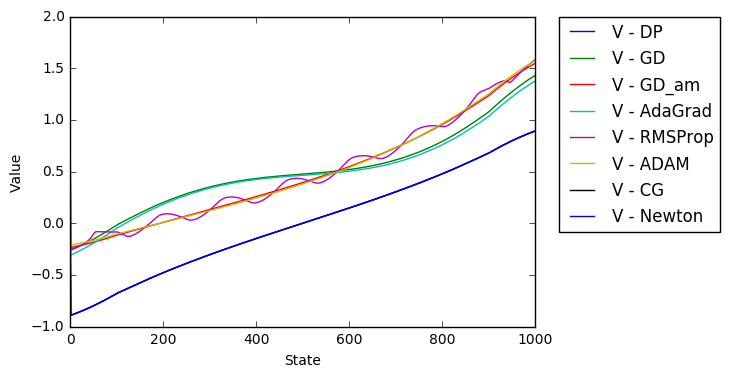

In [15]:
#plot the learned value functions
#plot the learning curves
for algo in range(nAlgos):
    plt.plot(v[0,algo,nIter,:],label='V - '+algos[algo])


plt.xlabel('State')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 2.3 Linear approximation

In [ ]:
#First, compute the optimal parameter vector, theta
nIter=10000
history=True

algos=['DP','CG']
algos=['DP','GD','GD_am','GD_ADAM','CG']

nAlgos=len(algos)


#compute theta
if(history):
    theta_history=np.zeros((nAlgos,nIter+1,problem.nFeatures+1))
    v_history=np.zeros((nAlgos,nIter+1,problem.nState+1)) 
    for algo in range(nAlgos):
        theta_history[algo,:]=problem.compute_valueFunction_approx(algos[algo],nIter,alpha=1.0,
                                                                   verbose=True,history=history,preconditionner=False)
        v_history[algo,:]=((problem.Phi).dot(theta_history[algo,:].T)).T
else:
    theta=np.zeros((nAlgos,problem.nFeatures+1))
    v=np.zeros((nAlgos,problem.nState+1))
    for algo in range(nAlgos):
        theta[algo,:]=problem.compute_valueFunction_approx(algos[algo],nIter,alpha=1.0,
                                                           verbose=True,history=history,preconditionner=False)
        v[algo,:]=(problem.Phi).dot(theta[algo,:]).T



#To compute the errors, we need to know the true value of v_TD
start=time.clock()
theta_TD = np.linalg.inv(problem.A_approx).dot(problem.b_approx)
v_TD = (problem.Phi).dot(theta_TD)
problem.theta=theta_TD
print 'Algo: Newton \t | Time (s):', time.clock()-start
print '\n\n'

#Now, compute errors
if(history):
    err_history=np.zeros((nAlgos,nIter+1))
    for algo in range(nAlgos):
        err_history[algo,:]=np.max(np.abs(v_history[algo,:]-v_TD),1)

else:
    for algo in range(nAlgos):
        print 'Algo:',algos[algo], '\t | final error:', np.max(np.abs(v[algo]-v_TD))

In [ ]:
#plot the learning curves
for algo in range(nAlgos):
    plt.semilogy(err_history[algo,:],label='Error - '+algos[algo])

plt.xlabel('Number of iterations of that algorithm')
plt.ylabel('Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
#plot the learned value functions
#plot the learning curves
for algo in range(nAlgos):
    plt.plot(v_history[algo,nIter,:],label='V - '+algos[algo])


plt.plot(v_TD,label='V_star')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Example in one dimension